In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
%matplotlib widget

In [2]:
%matplotlib inline
from COB_model import get_COB_model
from COBresolve import COBresolve_image
import higra as hg
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [3]:
weigth_path='COB_PASCALContext_trainval.h5'
input_shape=(None,None,3)
model=get_COB_model(weigth_path,input_shape)
predicter=COBresolve_image(model)


/home/sgr/Загрузки/cob_tf/python/COBresolve.py:100: RuntimeWarning: invalid value encountered in true_divide
  O=(np.sum(ab*w1w2,axis=0)/np.sum((ab>0)*w1w2,axis=0)*((ind1*ind2==0)+(abs(ind1-ind2)==1))-1)*np.pi/numClusters


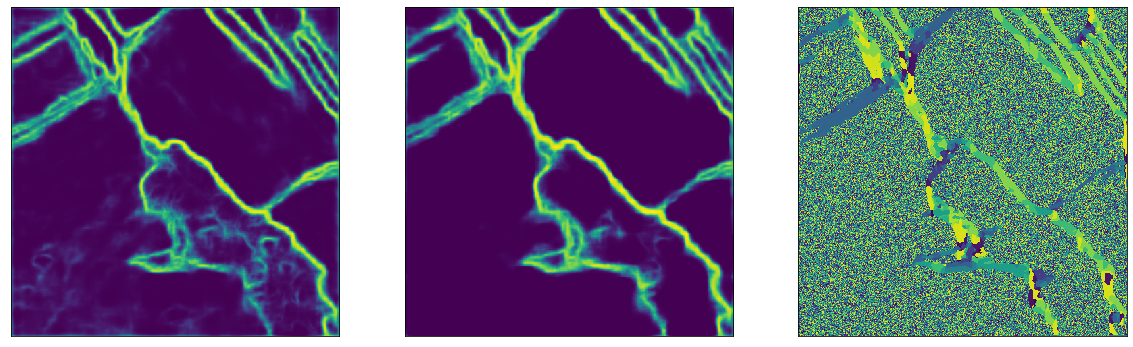

In [4]:
# image_name='10078660_15_cr.png'
# image_name='2010_005731.png'
image_name='2010_005731_.png'
# image_name='101087.jpg'
# image_name='2018.ppm'
base='../demo'
image_path = '{0}/{1}'.format(base,image_name)

image=np.asarray(Image.open(image_path))#.transpose(1,0,2)


output=predicter.resolve_imar(image)
# output=predicter.resolve_image(image_path)

plt.figure(figsize=(20,20))
for num, im in enumerate(output):
    plt.subplot(1,3,num+1)
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])

In [4]:
import os
from PIL import Image
import numpy as np
base_path='/media/sgr/storage/trash/clipped_sent'
fl_names=[fl for fl in os.listdir(base_path) if fl[-3:]=='tif']
fl_batch_names=sorted(list(set([nm.split('_',maxsplit=1)[0] for nm in fl_names])))
data=[]
for batch in fl_batch_names:    
    data.append(np.array([np.asarray(Image.open(os.path.join(base_path,fl_nm))) for fl_nm in fl_names if batch in fl_nm]))
    

In [161]:
def get_segments_table(segment_map, image):
    '''
    segment_map - indexed connected pixels groups where 0 - labeling masked area
    '''
    from skimage import measure
    from scipy import ndimage
    import pandas as pd    
    h,w,d=image.shape    
    index, reg_area = np.unique(segment_map,return_counts=True)    
    
    coord_lists=[(segment_map.ravel()==ind).nonzero()[0] for ind in index] 
    
    region_means=[np.array(i) for i in zip(*[ndimage.mean(image[:,:,band], labels=segment_map, index=index) for band in range(d)])]    
    return {index[i]: [reg_area[i], region_means[i]] for i in range (len(index))}

def get_board(segmented):
    "return boarder's length" 
    from scipy.signal import correlate2d
    kernel=[[0,1,0],[1,0,1],[0,1,0]]
    outlist={}
    for idx in np.unique(segmented):    
        corr=correlate2d((segmented==idx),kernel,mode='same')
        bord=corr*(segmented!=idx)        
        outlist[idx]= [(zone,np.sum(bord[(segmented==zone) & (bord>0)])) for zone in np.unique(segmented[bord>0])]
    return outlist

def get_dist(fv1,fv2):
    return np.sum((fv1-fv2)**2)

def get_neighbs_table(hhh, all_labels, thresh=100, zero_is_mask=True):
    thresh=thresh
    jj= get_board(all_labels)
    outdict={}
    for key in jj:
        if key==0 and zero_is_mask:
            continue
        for kk, lent in jj[key]:
            if kk==0 and zero_is_mask:
                continue
            areas=np.array([hhh[key][0],hhh[kk][0]])     

            if kk>key and np.min(areas)<thresh:
                features= np.array([hhh[key][1],hhh[kk][1]]) 
                dist=get_dist(*features)
                metr=(np.sum(areas)/np.prod(areas))*dist/lent
                outdict[(key, kk)]=[metr,lent]
    return outdict

def clear_merger (merge_list):
    merger=[[],[]]
    for i in merge_list[::-1]:
        if i[0] in merger[1]:            
            merger[0].append(merger[0][merger[1].index(i[0])])
            merger[1].append(i[1])
        else: 
            merger[0].append(i[0])
            merger[1].append(i[1])
    return merger

def get_clear_segm(all_labels, testim, thresh=100, zero_is_mask=True):
    hhh=get_segments_table(all_labels, testim)
    outdict=get_neighbs_table(hhh, all_labels, thresh, zero_is_mask)
    merger=[]
    
    while len(outdict)>0:
        minind=np.argmin(np.array(list(outdict.values()))[:,0])
        minpair=list(outdict.keys())[minind]
        merger.append(minpair)

        p,q=minpair
        ap, fp=hhh[p]
        aq, fq=hhh[q]
        hhh[p]=[ap+aq, (ap*fp+aq*fq)/(ap+aq)]


        for pair in [pair for pair in outdict if q in pair]:    
            pair_new = tuple([p if x==q else x for x in pair])
            if pair_new[0]==pair_new[1]: # выкинули старую пару
                outdict.pop(pair)
                continue    
            elif outdict.get(pair_new): # если пара с таким индексом уже существует
                lent=outdict[pair_new][1]+outdict[pair][1]        
            else: # если такого индекса не существует
                lent=outdict[pair][1]
                outdict.pop(pair)

            key,kk=pair_new

            features= np.array([hhh[key][1],hhh[kk][1]]) 
            dist=get_dist(*features)
            areas=np.array([hhh[key][0],hhh[kk][0]])
            metr=(np.sum(areas)/np.prod(areas))*dist/lent
            outdict[(key, kk)]=[metr,lent] 
            
            
        for key,kk in list(outdict.keys()):
            areas=np.array([hhh[key][0],hhh[kk][0]])
            if np.min(areas)>thresh:
                outdict.pop((key,kk)) 
                
    all_label1=np.copy(all_labels)
   
    for i in zip(*clear_merger(merger)):        
        all_label1[all_label1==i[1]]=i[0] 
    return all_label1


def get_contour_masked(output, masked):
    hh=np.copy(masked)
    hh[hh>0]=255

    from scipy import signal

    Ix=signal.correlate2d(hh[:,:,0],[[1,2,1],[0,0,0],[-1,-2,-1]], mode='same',boundary='symm')
    Iy=signal.correlate2d(hh[:,:,0],[[1,0,-1],[2,0,-2],[1,0,-1]], mode='same',boundary='symm')

    G = np.hypot(Ix, Iy)
  
    G = G / G.max()
  
    size = hh.shape[:2]

    gradient_coarse = np.array([output[1],G]).max(axis=0)
    gradient_fine = np.array([output[0],G]).max(axis=0)
    gradient_orientation = output[2]


    graph = hg.get_4_adjacency_graph(size)
    edge_weights_fine = hg.weight_graph(graph, gradient_fine, hg.WeightFunction.mean)
    edge_weights_coarse = hg.weight_graph(graph, gradient_coarse, hg.WeightFunction.mean)
    edge_weights_hig = hg.weight_graph(graph, G, hg.WeightFunction.mean)


    # special handling for angles to wrap around the trigonometric cycle...
    edge_orientations_source = hg.weight_graph(graph, gradient_orientation, hg.WeightFunction.source) 
    edge_orientations_target = hg.weight_graph(graph, gradient_orientation, hg.WeightFunction.target) 
    edge_orientations = hg.mean_angle_mod_pi(edge_orientations_source, edge_orientations_target)

    combined_hierarchy1, altitudes_combined1 = hg.multiscale_mean_pb_hierarchy(graph, edge_weights_fine, others_edge_weights=(edge_weights_coarse,), edge_orientations=edge_orientations)
    
    return hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(combined_hierarchy1, altitudes_combined1))

def get_segm_map(image,masked,line_thresh=0.2,area_thresh=20): 
    from skimage import measure
    line_thresh=line_thresh
    area_thresh=area_thresh
    im=masked
    mn= np.sum(im,axis=(0,1))/np.sum(im>0,axis=(0,1))
    mar=np.ma.array(im, mask=im>0)
    im_msk_mn=np.array(mar+mn.astype('uint8'))
    ott=np.array([image,im_msk_mn]).mean(axis=0).astype('uint8')
    cont_min_inside=get_contour_masked(predicter.resolve_imar(ott),im)
    outl=1-(cont_min_inside>line_thresh)
    segments= measure.label(outl)[::2,::2]
    
    if masked.ndim==3:
        masked=masked.prod(axis=2)>0
    
    segments[masked==0]=0
    segments= measure.label(segments)
    return get_clear_segm(segments,image,area_thresh)

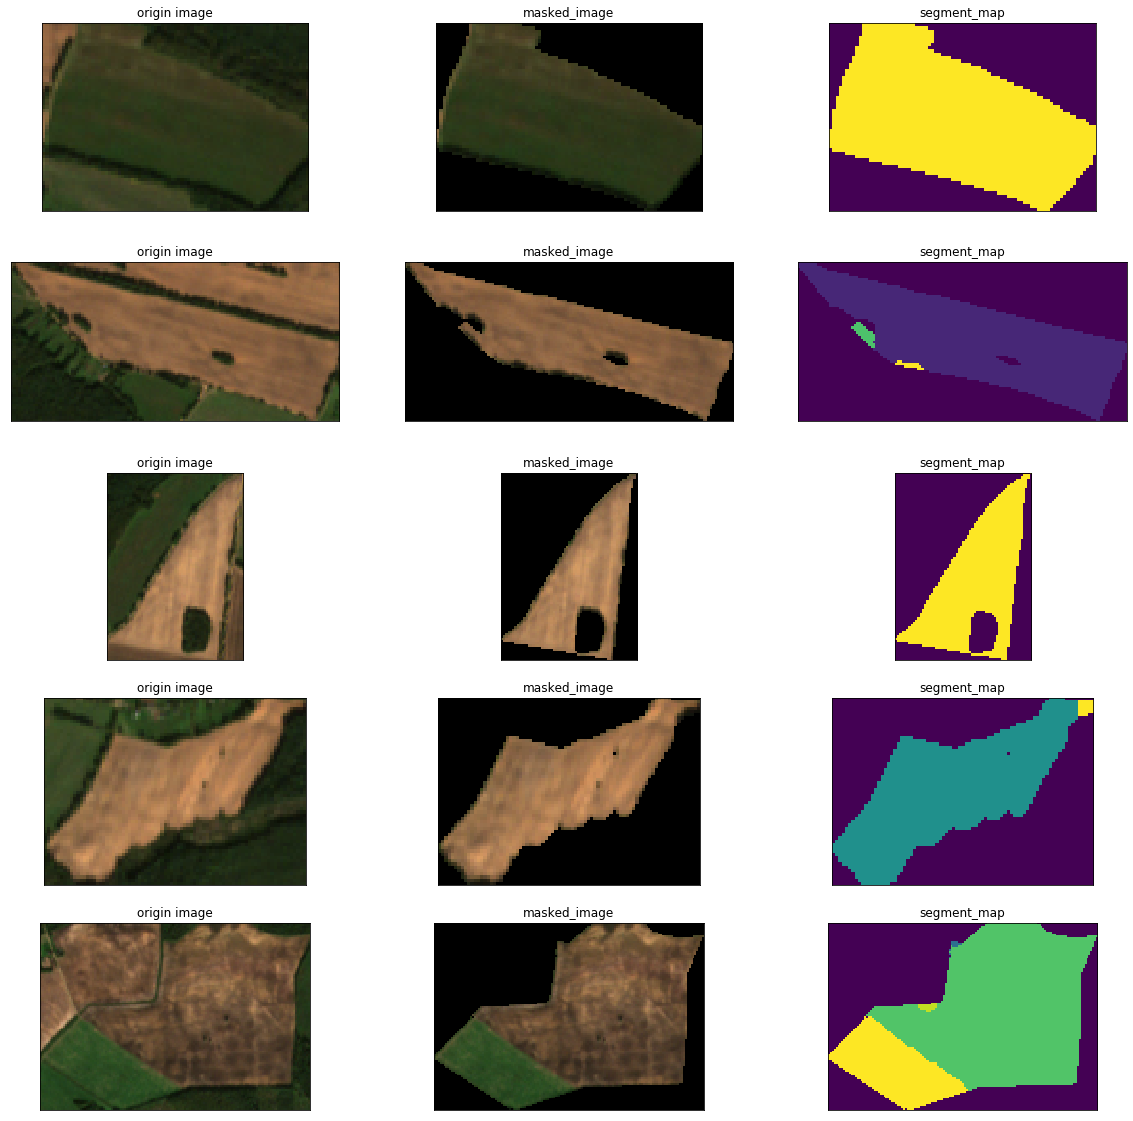

In [188]:
plt.figure(figsize=(20,20))

lines=len(data)
for line in range(lines):
    nm=line
    image=data[nm][0]
    masked=data[nm][1]
    seg_map=get_segm_map(image,masked,line_thresh=0.2,area_thresh=20)         
    
    for num,(im,title) in enumerate(zip([image,masked,seg_map],['origin image', 'masked_image', 'segment_map']),1):
        plt.subplot(lines,3,num+line*3)
        plt.imshow(im)
        plt.title(title)
        plt.xticks([]), plt.yticks([])



# plt.imshow(get_segm_map(data[nm][0],data[nm][1],line_thresh=0.2,area_thresh=20))

In [ ]:
import rasterio
from rasterio import features
import fiona
from shapely.geometry import shape
import numpy as np

In [195]:
#open raster & vector datasets
tif_path='/home/sgr/Загрузки/sent2020-0000000000-0000000000.tif'
dataset=rasterio.open(tif_path)
bands=dataset.count
bandnames=dataset.descriptions

# shape_path="/home/sgr/Загрузки/etalons_poly_shalow_class.shp"
shape_path="zip:///home/sgr/Загрузки/poly_classyfied.zip"
shp = fiona.open(shape_path, layer=0)
ittr=iter(shp)

In [215]:
#get next shape
geojson = next(ittr)
geom=shape(geojson['geometry'])
#get window and extract raster patch
wnd=features.geometry_window(dataset,[geojson],pad_x=2,pad_y=2, north_up=True, rotated=False, pixel_precision=5)
patch=dataset.read(window=wnd)
#calc transform for patch
new_transf=list(dataset.transform)
offs=dataset.transform*(wnd.col_off,wnd.row_off)
new_transf[2]=offs[0]
new_transf[5]=offs[1]
#get mask for patch
rows, cols = wnd.height,wnd.width
mask = features.rasterize([geom], out_shape=(rows, cols),transform=new_transf[:-3])

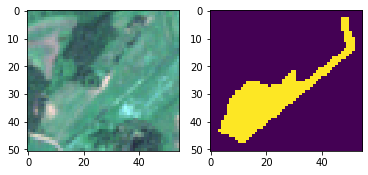

In [216]:
plt.subplot(1,2,1)
maxxx=np.max(patch,axis=(1,2))
plt.imshow((np.moveaxis(patch,0,2)/maxxx)[:,:,[2,1,0]])
plt.subplot(1,2,2)
plt.imshow(mask)

In [244]:
uu=dataset.sample([[609487,6154259]])
next(uu)

array([ 339,  543,  362,  863, 2168, 2603, 2871, 2784, 1237,  599],
      dtype=uint16)